# Introduction

The aim of this competition is to predict the survival of Titanic passengers. 1502 out of 2224 (67,5%) passengers died during the sinking. In this case survival is not solely explained by randomness: some groups of people were more likely to survive and the aim of the project is to identity the passengers caracteristics which could correlate with survival.

As we are predicting the survival of passenger we are going to employ binary classification machine learning techniques to solve this problem.

# Data Exploration

In [1]:
import numpy as np
import pandas as pd

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
filetrain = 'titanic/train.csv'
train_data = pd.read_csv(filetrain)
testfile = 'titanic/test.csv'
test_data =  pd.read_csv(testfile)

print('Train data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

train_data.head()

Train data shape:  (891, 12)
Test data shape:  (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The training data has 891 observations which is a few and 12 features (variables) including the the label we want to predict: *'Survived'*.
Based on the low number of observations we should aim for a simple model.

## Features Description

- *PassengerId*: Unique id per passenger. We won't use it as a feature for the training of our ML model.
- *Survived*: Categorical, this is the target variable for this problem.
- *Pclass*: Categorical (ordinal), describes the passenger class. It is a proxy for socio-economic status. A priori it is an important feature.
- *Name*: Text. Contains numerous information as the passenger's names and title.
- *Sex*: Categorical (nominal). A priori it is an important feature.
- *Age*: Numerical (continous). A priori it is an important feature.
- *SibSp*: Numerical (discrete). The number of siblings and spouses aboard.
- *Parch*: Numerical (discrete). The number of parents and children aboard.
- *Ticket*: Text. Ticket id.
- *Fare*: Numeric (continous). Price paid for the travel.
- *Cabin*: Text. Contains alphanumeric caracters.
- *Embarked*: Categorical (nominal). Embarkment's port.

Extra documentation available [here](https://www.kaggle.com/c/titanic/data).

## Check for missing values

In [4]:
train_data.info()
print()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass 

- *Age*, *Cabin* and *Embarked* contains some missing values in the train dataset.
- *Age*, *Fare* and *Cabin* contains some missing values in the test dataset.

We will need to find a clever way to handle missing values.

## Features analysis

In [5]:
train_data.pivot_table(index="Pclass",values='Survived').reset_index()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [6]:
train_data.pivot_table(index="Sex",values='Survived').reset_index()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [7]:
train_data.pivot_table(index="Embarked",values='Survived').reset_index()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Features as Pclass, Sex and Embarked seems to have a significant correlation with survival and we should keep them to build our model.
However we can't find a correlation between SibSp/Parch and Survived at first glance. These features might need extra work before using them.

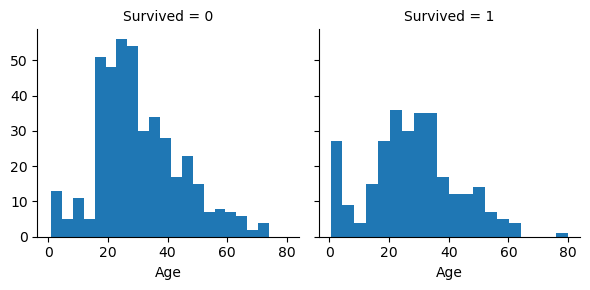

In [8]:
# Plot survival per Age bin
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)
plt.show()

- We can observe that infants (Age <=5) have a high survival rate.
- Most passengers are in the range 20 - 40 which appears to have about 50% chance of survival.

It might be a good idea to use this feature by creating age groups.

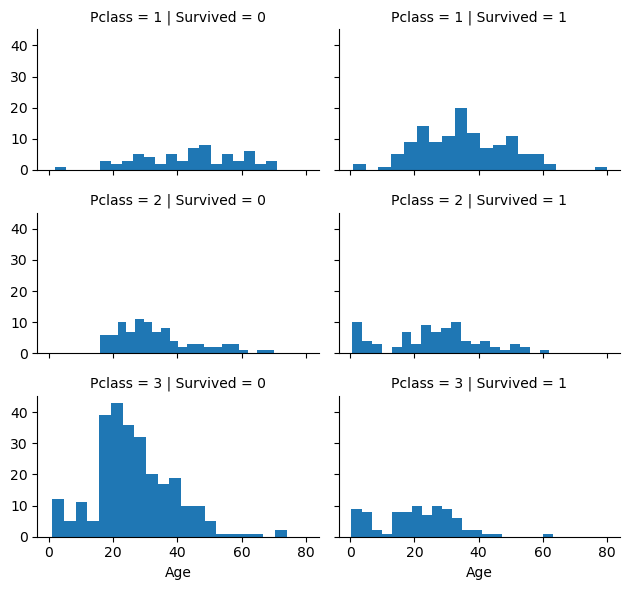

In [9]:
g = sns.FacetGrid(train_data, col='Survived', row='Pclass', height=2, aspect=1.6)
g.map(plt.hist, 'Age', bins=20)
plt.show()

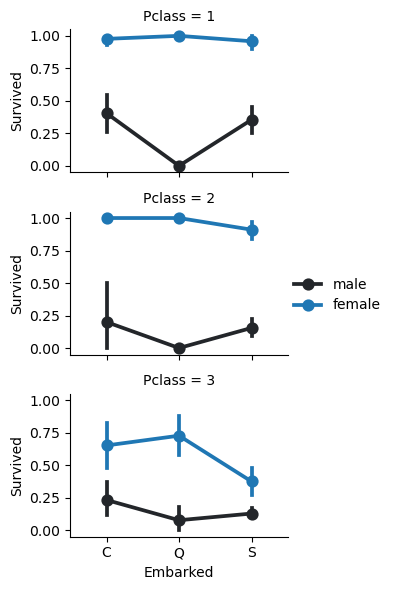

In [10]:
g = sns.FacetGrid(train_data, row='Pclass', height=2, aspect=1.6)
g.map(sns.pointplot, 'Embarked', 'Survived', 'Sex', hue_order=['male', 'female'], order=['C', 'Q', 'S'])
g.add_legend()
plt.show()

There is a relation between passenger Sex, Class and the survival rate. It might be a good idea to combine Sex and Pclass to create a feature.
Moreover we can observe that the embarkment has an impact on survival rate, and this impact is stronger on male passengers.

### Fare

In [11]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

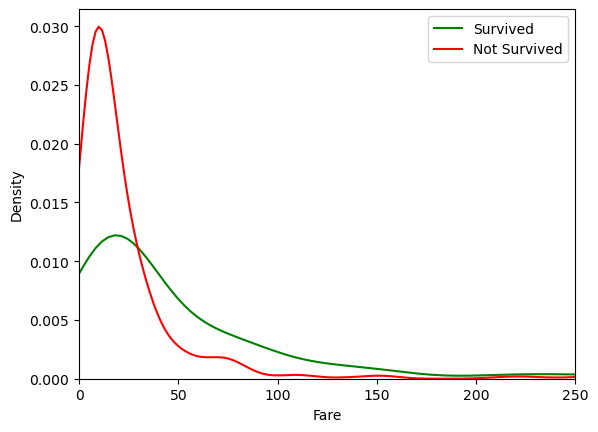

In [12]:
sns.kdeplot(train_data['Fare'][train_data.Survived == 1], color="green")
sns.kdeplot(train_data['Fare'][train_data.Survived == 0], color="red")
plt.legend(['Survived', 'Not Survived'])
plt.xlim(0, 250) # Remove the tail
plt.show()

- There are some 0's fares and we should investigate the reason why. Maybe it is for crew members?
- There is a spike in range 0-20 with a high mortality rate (about 3 times the chances of survival).
- After this range it looks like passengers are more likely to survive than to die but this relationship is also captured in Pclass so we might not need it.

Based on these observations it looks like Fare will be a useful feature for our model.

In [13]:
# Lets investigate fares=0
train_data[train_data['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


There is only one survivant amongs the 15 passengers with fare=0. Moreover we observe that they are males and have no siblings nor parents. Most of the time their cabin is not indicated and they embarked at Southampton which is the first embarkment port but also the most popular one (922 passengers over 1316).
Having fare=0 seems to be a big deal for estimating survival so we should create a feature with a column like 'has_paid_ticket'.

### Cabin Feature

In [14]:
train_data['Cabin'].value_counts(dropna=False, normalize=True)

Cabin
NaN            0.771044
C23 C25 C27    0.004489
G6             0.004489
B96 B98        0.004489
F2             0.003367
                 ...   
E36            0.001122
C106           0.001122
A19            0.001122
D7             0.001122
C82            0.001122
Name: proportion, Length: 148, dtype: float64

There is a lot of missing values for this feature: about 77%.

We can observe that the feature is composed of a letter and a number. The letter stands for the deck and the number for the room number.
The deck might have an influence on survival as it might have been harder to survive on lower decks.

Here is a plan of the ship with the decks: http://ssmaritime.com/Titanic-3.htm

**EDIT:** After many trials it looks like this feature is not bringing anything to the model so I decided to drop it.

# Data Cleaning / Feature Engineering

## Prepare dataset for training

Combine train and test to ease the process of feature engineering

In [15]:
def merge_datasets(train, test):
    columns_to_keep = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Fare', 'Embarked']
    columns_to_keep.extend(['Survived', 'is_train'])
    
    test['Survived'] = None
    train['is_train'] = True
    test['is_train'] = False
    
    combined_df = pd.concat([train[columns_to_keep], test[columns_to_keep]])
    combined_df['Survived'] = combined_df['Survived'].astype(float)
    
    return combined_df

combined = merge_datasets(train_data, test_data)
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Cabin,Fare,Embarked,Survived,is_train
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,NaN,7.2500,S,0.0,True
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,C85,71.2833,C,1.0,True
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,NaN,7.9250,S,1.0,True
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,C123,53.1000,S,1.0,True
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,NaN,8.0500,S,0.0,True


## Handle Missing values

We need to complete missing values for columns *Age*, *Cabin*, *Embarked*, *Fare* .

Missing age: https://www.kaggle.com/allohvk/titanic-missing-age-imputation-tutorial-advanced

In [16]:
import regex as re

titles_mapping = {
        "Mr" :         "Mr",
        "Capt":        "Mr",
        "Col":         "Mr",
        "Major":       "Mr",
        "Dr":          "Mr",
        "Rev":         "Mr",
        "Jonkheer":    "Mr",
        "Don":         "Mr",
        "Sir" :        "Mr",
        "Mme":         "Mrs",
        "Mrs" :        "Mrs",
        "Countess":    "Mrs",
        "Dona":        "Mrs",
        "Lady" :       "Mrs",
        "Master" :     "Master", # Master means boy child here
        "Ms":          "Miss",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
    }

def find_title_family(name):
    p = re.compile(' ([A-Za-z]+)\.')
    title = p.search(name).group(1)
    return titles_mapping[title]

In [17]:
def fill_missing(combined):
    df = combined.copy()
    
    df['Embarked'] = df['Embarked'].fillna('S')
    
    df['Cabin'] = df['Cabin'].fillna('X')
    
    df['title'] = df['Name'].apply(find_title_family)
    
    age_group = df.groupby(['Pclass', 'title'])['Age'].mean().reset_index()
    
    def fill_age(x):
        return age_group[(age_group['Pclass'] == x['Pclass']) & 
                         (age_group['title'] == x['title'])]['Age'].values[0]
    
    df['Age'] = df.apply(lambda x: fill_age(x) if np.isnan(x['Age']) else x['Age'], axis=1)
    
    df['Fare'] = df['Fare'].fillna(df[df['Pclass'] == 3]['Fare'].median()) # There is 1 passenger without Fare
    
    return df
    
combined_filled = fill_missing(combined)

## Creates new features

In [30]:
# Extract deck out of Cabin column
combined_filled['deck'] = combined_filled['Cabin'].str.slice(0, 1)

# Extract Title out of Name column
combined_filled['title'] = combined_filled['Name'].apply(find_title_family)
combined_filled['surname'] = combined_filled['Name'].apply(lambda x: x.split(',')[0])

# Group Features
combined_filled['family_size'] = combined_filled['SibSp'] + combined_filled['Parch'] + 1

# People with the same fare are most likely to have bougth their tickets together
combined_filled['ticket_freq'] = combined_filled['Ticket'].map(combined_filled['Ticket'].value_counts())
combined_filled['fare_freq'] = combined_filled['Fare'].map(combined_filled['Fare'].value_counts())

combined_filled['is_large_family'] = combined_filled['family_size'] > 4

# Create has_fare feature
combined_filled['has_fare'] = combined_filled['Fare'] != 0

# Compute real fare
combined_filled['fare_per_ticket'] = combined_filled['Fare'] / combined_filled['ticket_freq']

# Create Fare bands
combined_filled['fare_band'] = pd.qcut(combined_filled['fare_per_ticket'], 5, labels=[0, 1, 2, 3, 4])

# Create Age bands
def find_age_band(age):
    if age < 14:
        return 0
    elif age <= 30:
        return 2
    elif age <= 64:
        return 1
    else: 
        return 3

combined_filled['age_band'] = combined_filled['Age'].apply(find_age_band)
combined_filled['is_minor'] = combined_filled['age_band'] == 0

combined_filled['embarked_C'] = combined_filled['Embarked'].apply(lambda x: 1 if x == 'C' else 0)

# combined_filled.info()

combined_filled.loc[combined_filled['surname'] == 'Cumings']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Cabin,Fare,Embarked,...,is_large_family,has_fare,fare_per_ticket,fare_band,age_band,is_minor,embarked_C,ticket_formatted,group_id,group_freq
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,C85,71.2833,C,...,False,True,35.64165,4,1,False,1,C-PC 175XX-71.2833,no_group,1065
234,1,"Cumings, Mr. John Bradley",male,39.0,1,0,PC 17599,C85,71.2833,C,...,False,True,35.64165,4,1,False,1,C-PC 175XX-71.2833,no_group,1065


In [48]:
combined_filled['ticket_formatted'] = combined_filled['Embarked'] \
    + '-' + combined_filled['Ticket'].astype(str).str.slice_replace(-2, repl='XX') \
    + '-' + combined_filled['Fare'].astype(str)

combined_filled['group_id'] = combined_filled['surname'] \
    + '-' + combined_filled['Pclass'].astype(str) \
    + '-' + combined_filled['ticket_formatted']

combined_filled['group_id'] = combined_filled.apply(
    lambda x: 'no_group' if x['title'] == 'Mr' else x['group_id'], axis=1)

combined_filled['group_freq'] = combined_filled['group_id'].map(combined_filled['group_id'].value_counts())

combined_filled['group_id'] = combined_filled.apply(
    lambda x: 'no_group' if x['group_freq'] <= 1 else x['group_id'], axis=1)

# Add nanies and relatives
group = combined_filled[combined_filled['group_id'] != 'no_group']
for i, row in combined_filled.iterrows():
    if (row['title'] != 'Mr') & (row['group_id'] == 'no_group'):
        if group[group['ticket_formatted'] == row['ticket_formatted']].shape[0] > 0:
            combined_filled.at[i, 'group_id'] = group[group['ticket_formatted'] == row['ticket_formatted']].iloc[0]['group_id']

combined_filled['group_freq'] = combined_filled['group_id'].map(combined_filled['group_id'].value_counts())

combined_filled['group_survival'] = combined_filled['group_id'].map(
    combined_filled[combined_filled['is_train']].groupby('group_id')['Survived'].mean())

survival_rates_sex_class = combined_filled[(combined_filled['is_train'] == True) & (combined_filled['group_id'] == 'no_group')].groupby(['Pclass', 'Sex']).mean()['Survived'] \
    .reset_index()

# Set group survival rate according to average survival rate for alone people of same Sex and Pclass
# combined_filled['group_survival'] = combined_filled.apply(
#     lambda x: combined_filled[(combined_filled['is_train'] == True) \
#                 & (combined_filled['group_id'] == 'no_group') \
#                 & (combined_filled['Pclass'] == x['Pclass']) \
#                 & (combined_filled['Sex'] == x['Sex'])] \
#     .mean()['Survived'] if x['group_id'] == 'no_group' else x['group_survival'],
#     axis=1)

# def set_survival_na(x):
#     if pd.isna(x['group_survival']):
#         return combined_filled[combined_filled['group_freq'] == x['group_freq']].mean()['group_survival']
#     else:
#         return x['group_survival']

# # For NaN, set to average survival rate for group of some frequency
# combined_filled['group_survival'] = combined_filled.apply(set_survival_na, axis=1)

combined_filled

TypeError: agg function failed [how->mean,dtype->object]

## Feature Preparation

Prepare features of the dataset before beeing able to pass them to train / test our ML model.

In [22]:
from sklearn.preprocessing import minmax_scale, StandardScaler

def dummy_encoding(df, feature):
    dummies = pd.get_dummies(df[feature], prefix=feature, drop_first=True)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop(feature, axis=1)
    return df

def prepare_features(df, features):
    """Make the feature usable by an ML algorithm"""
    df = df.copy()
    
    for col in df.columns:
        if col not in features['nominal'] + features['ordinal'] \
            + features['boolean'] + features['numeric'] + ['is_train', 'Survived']:
            df = df.drop(col, axis=1)
    
    # Transform useful features
    for feature in features['nominal']:
        df[feature] = df[feature].astype('category')
        df = dummy_encoding(df, feature)
    
    for feature in features['ordinal'] + features['boolean']:
        df[feature] = df[feature].astype('int')
    
    for feature in features['ordinal'] + features['numeric']:
        scaler = StandardScaler()
        df[[feature]] = scaler.fit_transform(df[[feature]])
        df[feature + '_scaled'] = df[feature]
        df = df.drop(feature, axis=1)
    
    return df
    
# Define type of each feature
features = {
    'nominal': ['Sex'], # sex*pclass, 'title'
    'ordinal': ['Pclass', 'fare_band'], # 'age_band'
    'boolean': ['is_minor'], # 'embarked_C', 'is_large_family', 'has_fare', 'is_minor'
    'numeric': ['group_survival'], # ['fare_per_ticket', 'Age']
}
combined_prepared = prepare_features(combined_filled, features)
combined_prepared.head()

KeyError: "None of [Index(['group_survival'], dtype='object')] are in the [columns]"

# Train / Predict

In [20]:
X_train = combined_prepared[combined_prepared['is_train'] == 1].drop(['Survived', 'is_train'], axis=1)
y_train = combined_prepared[combined_prepared['is_train'] == 1]['Survived'].astype(int)

X_test = combined_prepared[combined_prepared['is_train'] == 0].drop(['Survived', 'is_train'], axis=1)

NameError: name 'combined_prepared' is not defined

In [21]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    random_state=2,
    n_estimators=25,
    min_samples_split=20,
    oob_score=True)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

results = pd.DataFrame({
    "PassengerId": test_data['PassengerId'],
    "Survived": predictions
})

results.to_csv('submission.csv', index=False)

print('Submission file has been exported.')
results.head()

NameError: name 'X_train' is not defined